In [1]:
import pandas as pd
import numpy as np
from vizual.vizual_lib import VizualLib
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("./origin_data/russia_losses_personnel.csv")
data

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0.0
1,2022-02-26,3,4300,about,0.0
2,2022-02-27,4,4500,about,0.0
3,2022-02-28,5,5300,about,0.0
4,2022-03-01,6,5710,about,200.0
...,...,...,...,...,...
684,2024-01-10,686,366790,about,NaN
685,2024-01-11,687,367620,about,NaN
686,2024-01-12,688,368460,about,NaN
687,2024-01-13,689,369160,about,NaN


In [3]:
data = data[['date', 'personnel']]

In [4]:
data.rename(columns={"personnel": "Losses", "date": "Date"}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

C:\Users\user\AppData\Local\Temp\ipykernel_10656\2052709274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={"personnel": "Losses", "date": "Date"}, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_10656\2052709274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


In [5]:
data

,Losses
Date,
2022-02-25,2800
2022-02-26,4300
2022-02-27,4500
2022-02-28,5300
2022-03-01,5710
...,...
2024-01-10,366790
2024-01-11,367620
2024-01-12,368460


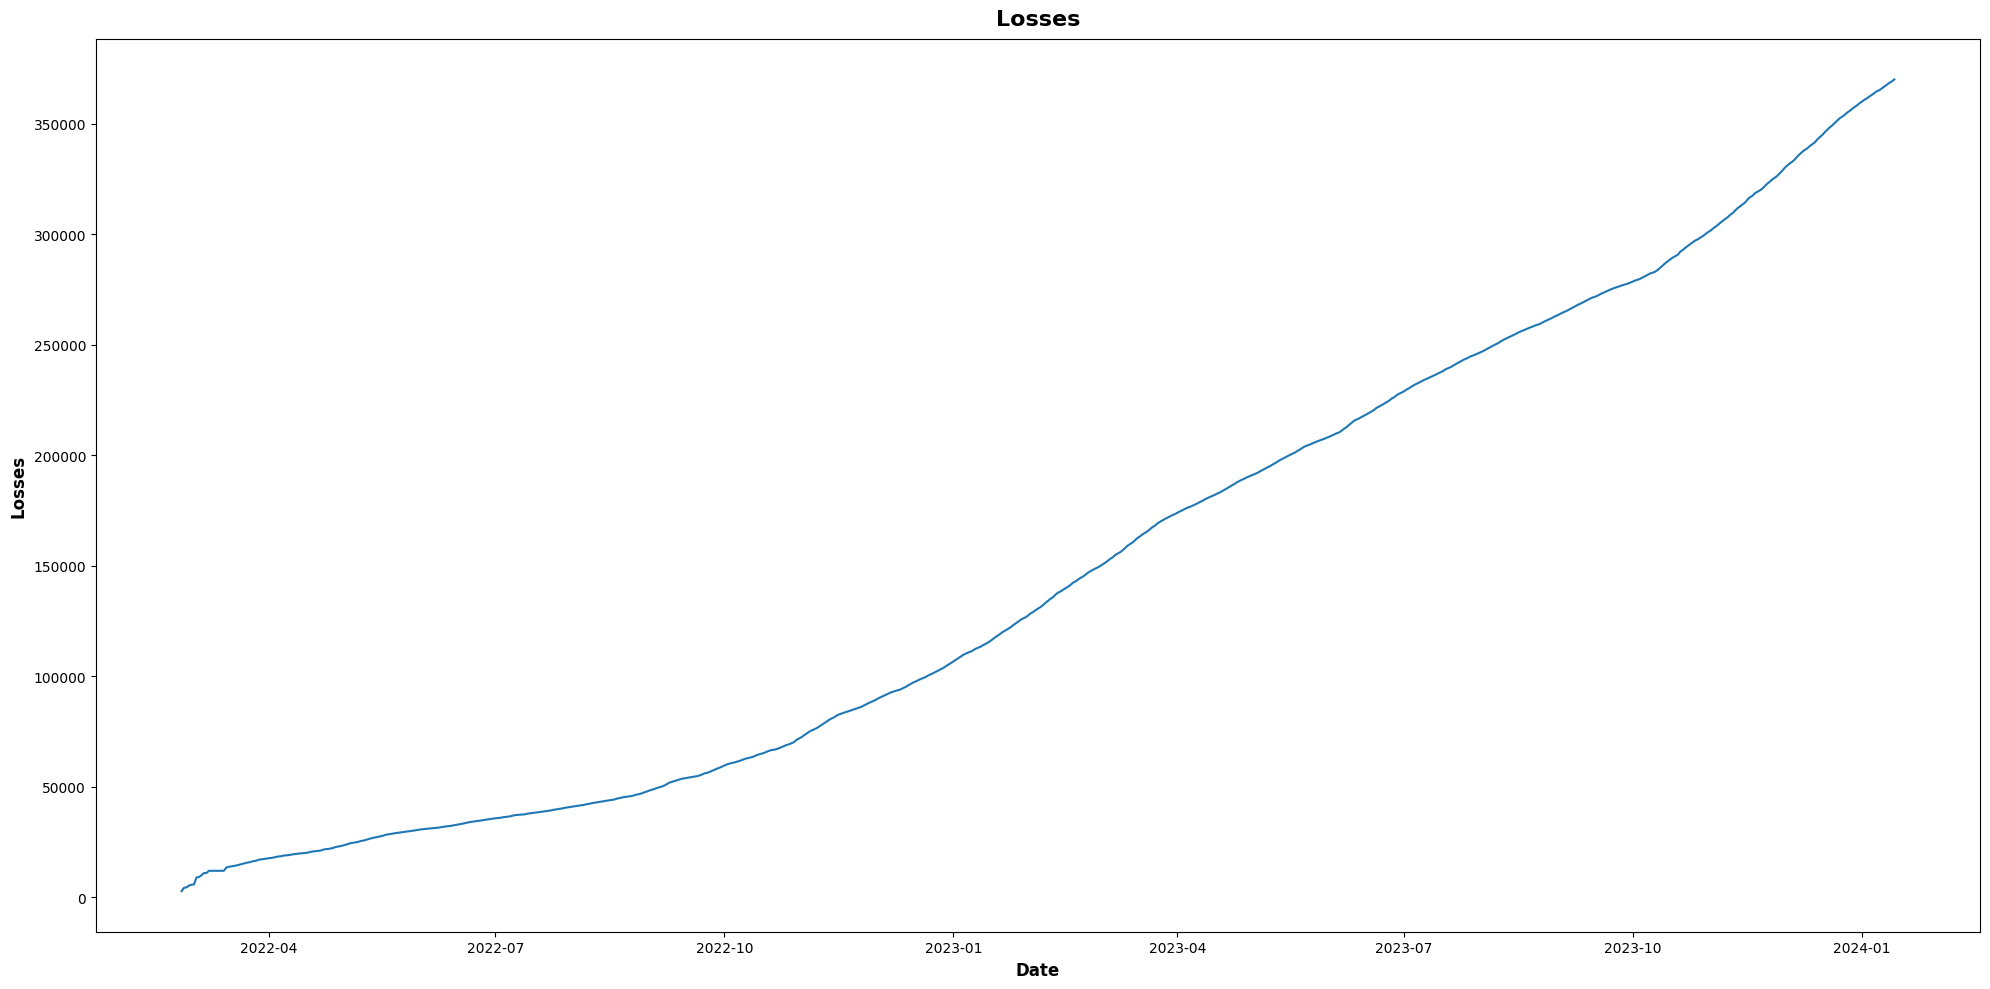

In [6]:
VizualLib.figure(data)

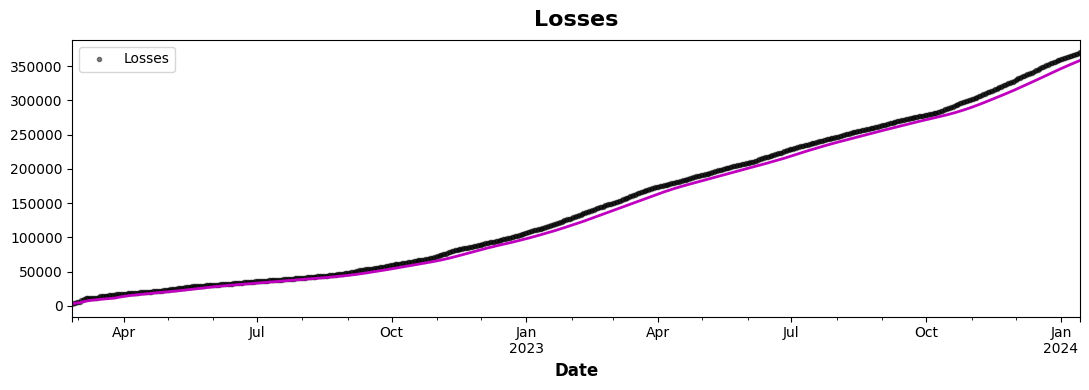

In [7]:
VizualLib.moving_average(data, rolling=30, min_periods=1, color='#00000078')

In [8]:
dp = DeterministicProcess(
    data.index,
    order=1
)
X = dp.in_sample()

In [9]:
X

,trend
Date,
2022-02-25,1.0
2022-02-26,2.0
2022-02-27,3.0
2022-02-28,4.0
2022-03-01,5.0
...,...
2024-01-10,685.0
2024-01-11,686.0
2024-01-12,687.0


In [10]:
X_train, X_valid = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_valid = train_test_split(data, test_size=0.2, shuffle=False)

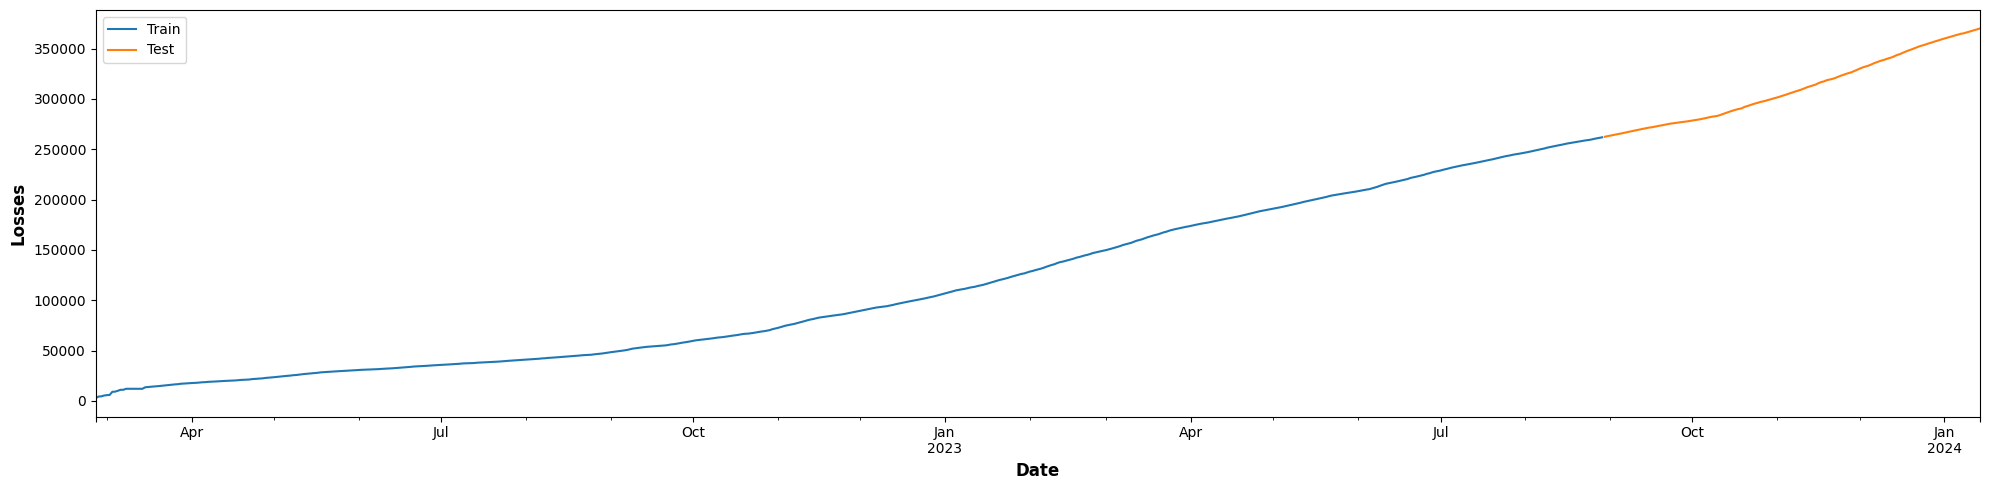

In [11]:
import matplotlib.pyplot as plt
ax = y_train.plot(figsize=(20, 5))
y_valid.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Losses')
plt.show()

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_valid),
    index=y_valid.index,
    columns=y_valid.columns,
)

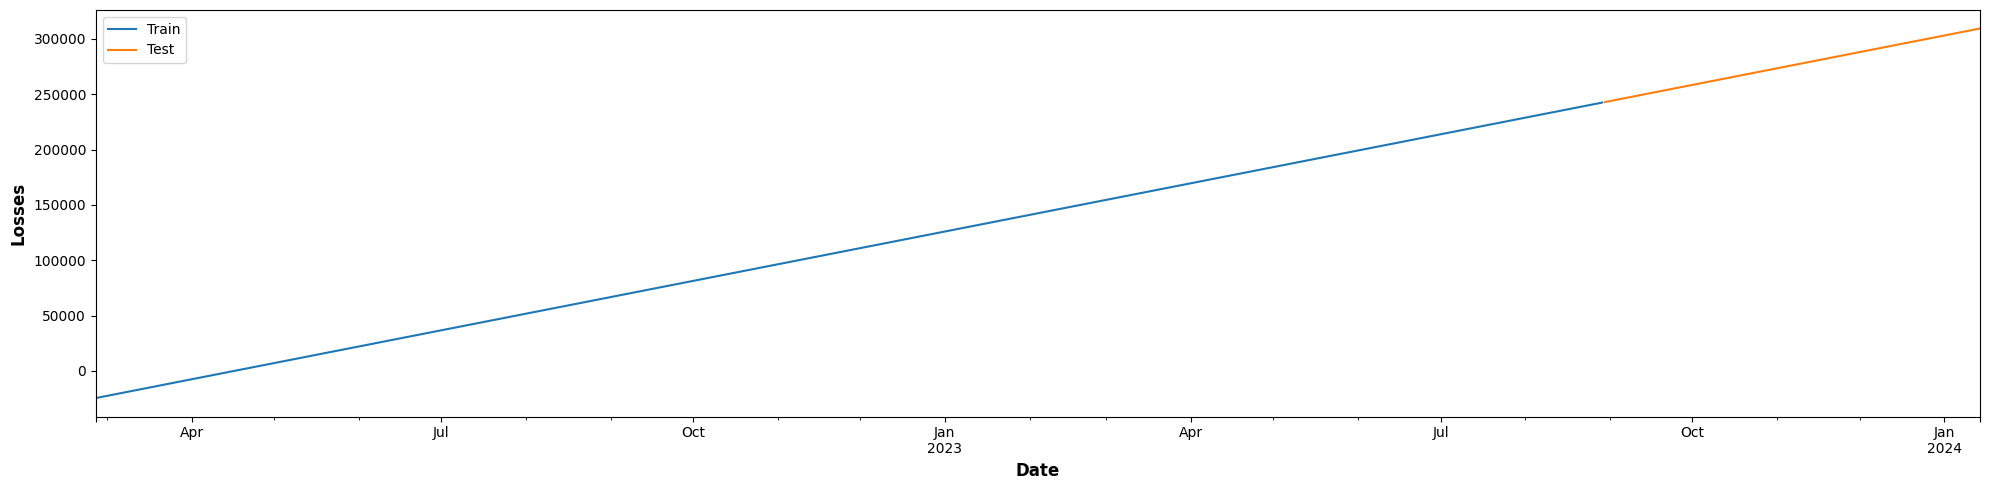

In [13]:
ax = y_fit.plot(figsize=(20, 5))
y_pred.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Losses')
plt.show()

In [14]:
y_resid = y_train - y_fit

In [15]:
y_resid

,Losses
Date,
2022-02-25,27413.076521
2022-02-26,28427.487502
2022-02-27,28141.898482
2022-02-28,28456.309463
2022-03-01,28380.720443
...,...
2023-08-25,19111.471934
2023-08-26,19265.882915
2023-08-27,19330.293895


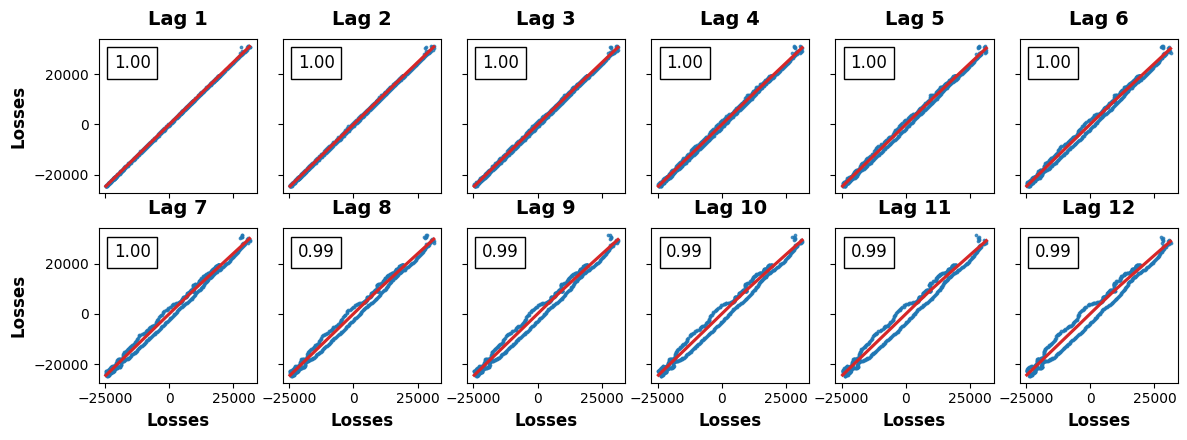

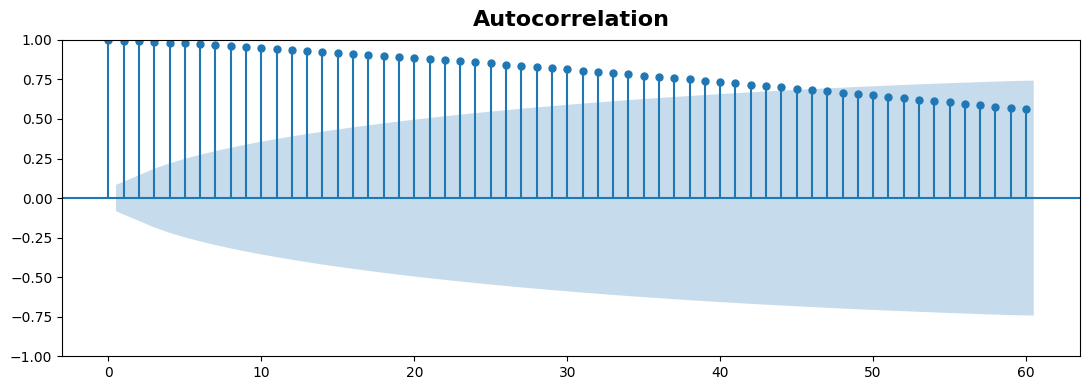

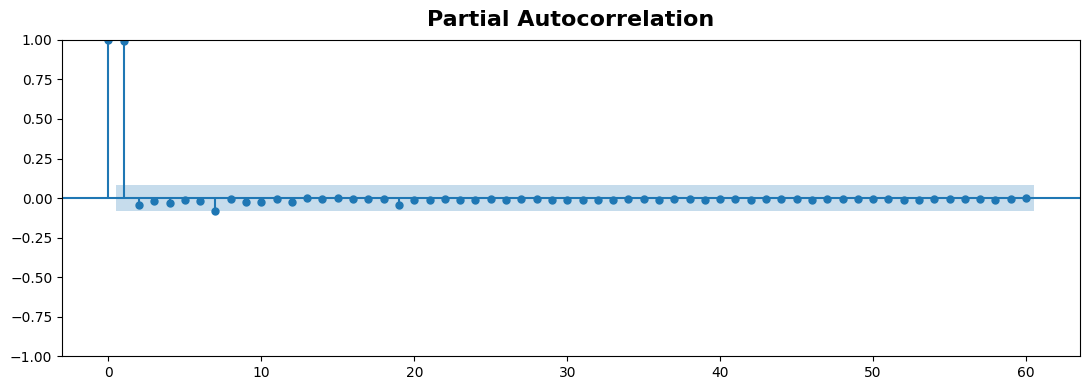

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
VizualLib.plot_lags(y_resid['Losses'], lags=12, nrows=2)
plot_acf(y_resid['Losses'], lags=60)
plot_pacf(y_resid['Losses'], lags=60)
plt.tight_layout()

In [22]:
from statsmodels.tsa.stattools import adfuller

def ad_test(data):
    dftest = adfuller(data, autolag = 'AIC')
    print("1. ADF : ", dftest[0]) 
    print("2. P-Value : ", dftest[1]) 
    print("3. Num of Lags : ", dftest[2]) 
    print("4. Num of Observations Used for ADF Regression and Critical Values Calculation : ", dftest[3])

ad_test(y_resid)

1. ADF :  -2.9693376923283727
2. P-Value :  0.03785879510041319
3. Num of Lags :  6
4. Num of Observations Used for ADF Regression and Critical Values Calculation :  544


In [24]:
from pmdarima import auto_arima
ARIMA_model = auto_arima(y_resid['Losses'],
                         stepwise=True)
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  551
Model:               SARIMAX(4, 2, 1)   Log Likelihood               -3667.977
Date:                Thu, 18 Jan 2024   AIC                           7347.954
Time:                        21:05:31   BIC                           7373.803
Sample:                    02-25-2022   HQIC                          7358.056
                         - 08-29-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2797      0.040     -6.907      0.000      -0.359      -0.200
ar.L2         -0.1901      0.045     -4.271      0.000      -0.277      -0.103
ar.L3         -0.0696      0.036     -1.942      0.052      -0.140       0.001
ar.L4         -0.3131      0.025    -12.764      0.000      -0.361      -0.265
ma.L1         -0.5004      0.049    -10.230      0.000      -0.596      -0.405
sigma2      3.358e+04    807.241     41.602      0.000     3.2e+04    3.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             43900.66
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             2.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_resid, order=(4, 2, 6))
model = model.fit()

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
start = len(y_resid)
end = len(y_resid) + len(y_valid)
pred = model.predict(start=start, end=end)
print(pred)

2023-08-30    19417.004364
2023-08-31    19384.006020
2023-09-01    19454.313255
2023-09-02    19520.900998
2023-09-03    19529.589223
                  ...     
2024-01-11    23061.383062
2024-01-12    23134.075811
2024-01-13    23140.563877
2024-01-14    23151.302357
2024-01-15    23145.694205
Freq: D, Name: predicted_mean, Length: 139, dtype: float64


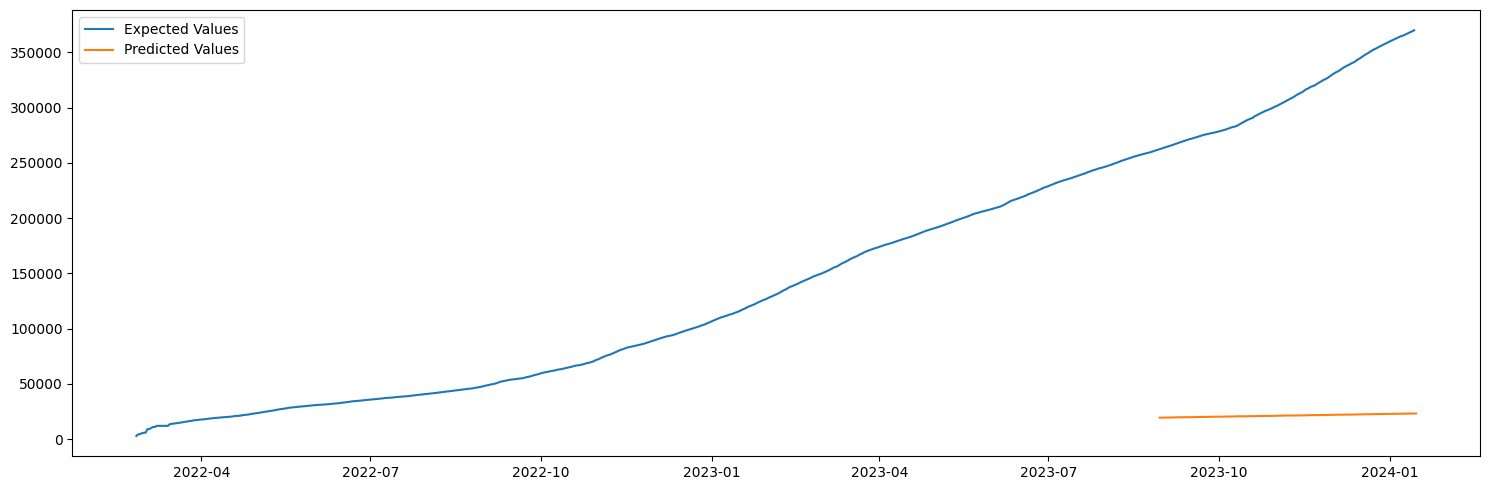

In [39]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data, label = 'Expected Values')
plt.plot(pred, label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()
